In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
color_map = matplotlib.colors.ListedColormap(['r','g'])

### Utility funtions

These funtions help traverse the binray tree.
 - Should move to a class function someday
 

In [10]:
def printBtree(currIdx,nodeList,childList,rmrk=""):
    if currIdx==None:
        return
    offset="  "*nodeList[currIdx].depth+rmrk+' '
    if nodeList[currIdx].isLeaf:
        print(offset+f"Leaf with p_pos {nodeList[currIdx].p_pos:.3f}")
        return
    print(offset+f" X[:,{nodeList[currIdx].dimToCut}] < {nodeList[currIdx].cut:.2f}")
    printBtree(childList[currIdx][1],nodeList,childList,rmrk="False")
    printBtree(childList[currIdx][0],nodeList,childList,rmrk="True")


def evaluateBtree(X,currIdx,nodeList,childList)    :
    if currIdx==None:
        raise
    currNode=nodeList[currIdx]
    if currNode.isLeaf:
        return currNode.p_pos
    if X[currNode.dimToCut] < currNode.cut:
        return evaluateBtree(X,childList[currIdx][0],nodeList,childList)
    else:
        return evaluateBtree(X,childList[currIdx][1],nodeList,childList)    

## Making a Dummy Dset

    Here we make a dataset with two classes. The dataset is 2 - dimentional and have gausian distribution in each dimension. The mean and sigma of these gausians can be set separately

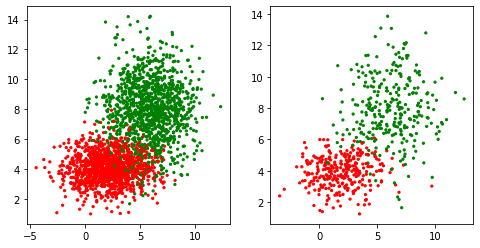

In [3]:
NMAX=int(1.5e3)
np.random.seed(seed=42)
x1=np.array([np.random.normal(2.0,2.0,NMAX),np.random.normal(4.0,1.0,NMAX)]).T
x2=np.array([np.random.normal(6.0,2.0,NMAX),np.random.normal(8.0,2.0,NMAX)]).T

X=np.concatenate([x1,x2])
Y=np.concatenate([np.zeros(len(x1)),np.ones(len(x2))])

rand_index=np.random.permutation(len(X))
nTrain=int(0.8*len(X))

x_train,y_train=X[rand_index[:nTrain]],Y[rand_index[:nTrain]]
x_test ,y_test =X[rand_index[nTrain:]],Y[rand_index[nTrain:]]

f,ax=plt.subplots(1,2,figsize=(8,4))

ax[0].scatter(x_train[:,0],x_train[:,1],c=y_train,cmap=color_map,s=5,alpha=1)
ax[1].scatter(x_test[:,0] ,x_test[:,1] ,c=y_test ,cmap=color_map,s=5,alpha=1)

## Descision Tree

In [4]:
class node():
    # This class defines individual nodes in a tree. 
    # Each node has capability to identify the optimal cut required to split 
    # and identify the left and right daugters
    
    def __init__(self,X=None,Y=[],depth=None,loss_fn=None):
        self.depth=depth # depth information of the node
        self.nDims=0 # dim of the datta being stored
        self.X=X
        self.Y=Y
        self.dimToCut=None # dimension choosen for the Cut
        self.cut=None # identifid optimal cut
        self.loss_fn=loss_fn # loss funtion that get minimized for the optimal cut
        self.isLeaf=False # if the node had daughters or not
        self.p_pos=-1.0 # purity
        self.p_neg=-1.0 # 
        
        if len(self.Y):
            self.p_pos=np.sum(self.Y)/len(self.Y)
            self.p_neg=1-self.p_pos
        pass
    
    def setOptimalCut(self):
        ## Ideally this funtion need to be rewritten to select the cut
        ## that can scan the cut values and dimension simultaneously 
        
        ## Scanning the Cuts 
        #    - here the Cut is chosen as the mid point separating the mean of inividual classes
        x_means_pos=np.mean(self.X[self.Y==1],axis=0)
        x_means_neg=np.mean(self.X[self.Y==0],axis=0)
        cuts = 0.5 * (x_means_pos + x_means_neg)
        n=len(x_means_pos)
        
        
        daughter_idx = self.X < cuts

        ## Minimizing the loss function across dimension
        loss=np.array( [ self.loss_fn(daughter_idx[:,i],self.Y) for i in range(daughter_idx.shape[1]) ] ) 
        idx=np.argmin(loss)
        
        self.cut = cuts[idx]
        self.dimToCut = idx
        
        return idx,cuts[idx]
        
    def evaluate(self,x,y=[],which='left'):
        # this funtion returns the left / right childs of a set of input items
        mask = x[:,self.dimToCut] < self.cut
        if which=='right':
            mask = np.logical_not(mask)
        if len(y) > 0:
            return x[ mask ] , y[mask]
        return x[ mask ]
                

In [15]:
class descisionTree(node):
    # Top level class that manges the Binary tree for desciion
    
    def __init__(self,X=None,Y=None,loss_fn=None,nDepthMax=3):
        super().__init__(X,Y,loss_fn=loss_fn)
        self.nDepthMax=nDepthMax # Max depth the tree can take
        
        ## Chosen format for the binary treee implementaion is array based
        ## Recusivesines in the implentation is avoided intentionally inside class function
        ## The nodeList contains all the nodes in the DT
        ## ith element in the childList is a tuple ( a , b ). 
        ##   a-th element in nodeList is left child node
        ##   b-th element in nodeList is right child node
        ##  if a/b == None -> No child
        
        self.nodeList=[]     # nodes for the B-Tree implementation
        self.childIdxList=[] # child list for the BTree implementaion
        
        self.depth=0 # initializing the depth of the superclass
        pass
    
    def fit(self):
        # Fit the DT for the input dataset
        
        nCurr=0
        nNodes=1
        
        # add the top level node to the nodelist.
        # nodelist will get populated by the child nodes as splitting hppen
        self.nodeList.append(self)
        self.childIdxList.append([None,None]) # initialize the 
        
        # loop over all the nodes available in the nodelist
        
        while nCurr < nNodes:
            currNode=self.nodeList[nCurr]
            
            if currNode.isLeaf:  # if the node is leaf , do not split
                pass
                
            
            elif currNode.depth < self.nDepthMax: # if the current  node is not the DEPTH MAX
                print("Splitting the node at depth : ",currNode.depth)
                
                if currNode.p_pos <0.05 or currNode.p_neg <0.05:
                    currNode.isLeaf = True  # if the node is very pure , do not split, assign Leaf
                
                
                currNode.setOptimalCut() # identify the optimal cut for the current node
                
                childIdxs=[None,None] # initailize the children of curent node as None
                
                ## Get Left and right children based on the optimal cut 
                X_left,Y_left =currNode.evaluate(currNode.X,currNode.Y,which='left') 
                X_right,Y_right=currNode.evaluate(currNode.X,currNode.Y,which='right')
                
                ## if there are children in left(right) collection
                ##    Make a new node with those children
                ##    Add it to node list
                ##    Add an entry to the childlist with [None,None]
                ##    Assign the new kid as the left(right) daughter of current node
                
                if len(Y_left) >0:
                    leftChild=node(X_left,Y_left,depth=currNode.depth+1,loss_fn=self.loss_fn)
                    self.nodeList.append(leftChild)
                    self.childIdxList.append([None,None])
                    childIdxs[0]=len(self.nodeList)-1
                
                if len(Y_right) >0:
                    rightChild=node(X_right,Y_right,depth=currNode.depth+1,loss_fn=self.loss_fn)
                    self.nodeList.append(rightChild)
                    self.childIdxList.append([None,None])
                    childIdxs[1]=len(self.nodeList)-1
                    
                ## Update the childIdxList for the current node
                self.childIdxList[nCurr]=childIdxs
            
            else: # if the depth has reached limit
                currNode.isLeaf=True
                
            nCurr+=1
            nNodes=len(self.nodeList)
                
    
        
    def predict_proba(self,X):
        # parse the Binary tree and return the final probabilit
        return evaluateBtree(X,0,self.nodeList,self.childIdxList)
    
    def printTree(self):
        # parse the Binary tree and pretty-print the DT
        printBtree(0,self.nodeList,self.childIdxList)
        pass
    

In [16]:
## Gini Loss Funtion
def gini(Y_pred,Y_true):
    y=np.array(Y_pred,dtype=bool)
    p=np.sum(Y_true[y])/(1e-9+len(Y_true))
    return p*(1-p)

### Initialize the Descision Treee

In [7]:
dt=descisionTree(x_train,y_train,loss_fn=gini,nDepthMax=3)

### Fit the DT

In [8]:
dt.fit()

Splitting the node at depth :  0
Splitting the node at depth :  1
Splitting the node at depth :  1
Splitting the node at depth :  2
Splitting the node at depth :  2
Splitting the node at depth :  2
Splitting the node at depth :  2


### Print the DT

In [11]:
dt.printTree()

  X[:,1] < 5.99
  False Leaf with p_pos 0.973
  True  X[:,0] < 4.01
    False  X[:,1] < 4.43
      False Leaf with p_pos 0.642
      True Leaf with p_pos 0.257
    True Leaf with p_pos 0.032


### Evaluate the DT

Text(0, 1, 'nEntries')

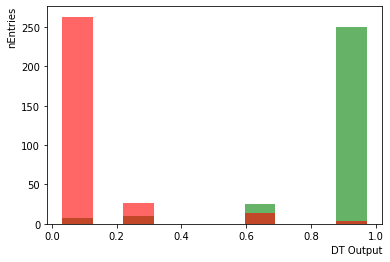

In [23]:
y_pred=np.array([ evaluateBtree(x_test[i],0,dt.nodeList,dt.childIdxList) for i in range(len(x_test)) ])

sMask= y_test > 0.5
bMask= y_test < 0.5

_=plt.hist(y_pred[sMask],color='g',alpha=0.6)
_=plt.hist(y_pred[bMask],color='r',alpha=0.6)
plt.xlabel("DT Output",loc='right')
plt.ylabel("nEntries",loc='top')

In [30]:
thr=0.5
yP = y_pred > thr

tp=np.sum( yP[sMask] )
fp=np.sum( yP[bMask] )

tn=np.sum(yP[bMask]==y_test[bMask])
fn=np.sum(yP[sMask]!=y_test[sMask])

print(f"At threashold = {thr} ,")
print(f"\t TPR : {tp/(tp+fn):.3f}")
print(f"\t FPR : {fp/(tp+fn):.3f}")
print(f"\t FNR : {fn/(tp+fn):.3f}")
print(f"\t TNR : {tn/(fn+tn):.3f}")

At threashold = 0.5 ,
	 TPR : 0.942
	 FPR : 0.062
	 FNR : 0.058
	 TNR : 0.945
